In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
import shap



Matplotlib is building the font cache; this may take a moment.


In [5]:
df = pd.read_csv(r"C:\Users\Varsh\Downloads\fraud\Fraud.csv")
df.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [6]:

df.isnull().sum()


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [12]:
import numpy as np
median_values = df.select_dtypes(include=[np.number]).median()
df.fillna(median_values, inplace=True)
quartiles = df.select_dtypes(include=[np.number]).quantile([0.25, 0.75])
Q1 = quartiles.loc[0.25]
Q3 = quartiles.loc[0.75]
IQR = Q3 - Q1
condition = ~((df.select_dtypes(include=[np.number]) < (Q1 - 1.5 * IQR)) |
              (df.select_dtypes(include=[np.number]) > (Q3 + 1.5 * IQR))).any(axis=1)
df = df[condition].reset_index(drop=True)

In [14]:
print(df.columns)

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')


In [17]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
X_temp = df.drop('is_fraud', axis=1, errors='ignore')
X_temp = X_temp.select_dtypes(include=[float, int])
vif_data = pd.DataFrame()
vif_data["feature"] = X_temp.columns
vif_data["VIF"] = [variance_inflation_factor(X_temp.values, i) for i in range(X_temp.shape[1])]
vif_data = vif_data.sort_values(by="VIF", ascending=False).reset_index(drop=True)

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

In [25]:
adf = df.copy()

In [27]:
print(adf.columns)
print(adf['isfraud'].head())

Index(['step', 'type', 'amount', 'nameorig', 'oldbalanceorg', 'newbalanceorig',
       'namedest', 'oldbalancedest', 'newbalancedest', 'isfraud',
       'isflaggedfraud'],
      dtype='object')
0    0
1    0
2    0
3    0
4    0
Name: isfraud, dtype: int64


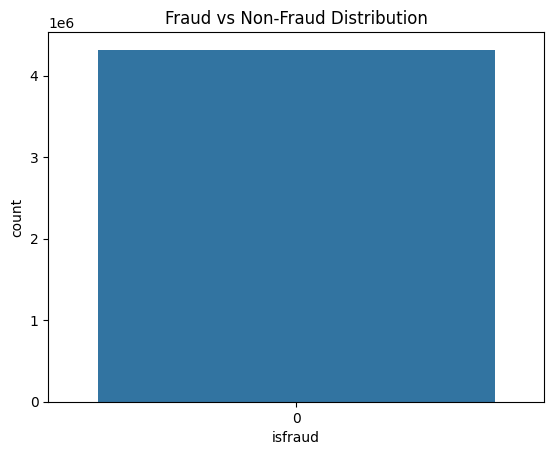

In [29]:
sns.countplot(x='isfraud', data=adf)
plt.title("Fraud vs Non-Fraud Distribution")
plt.show()

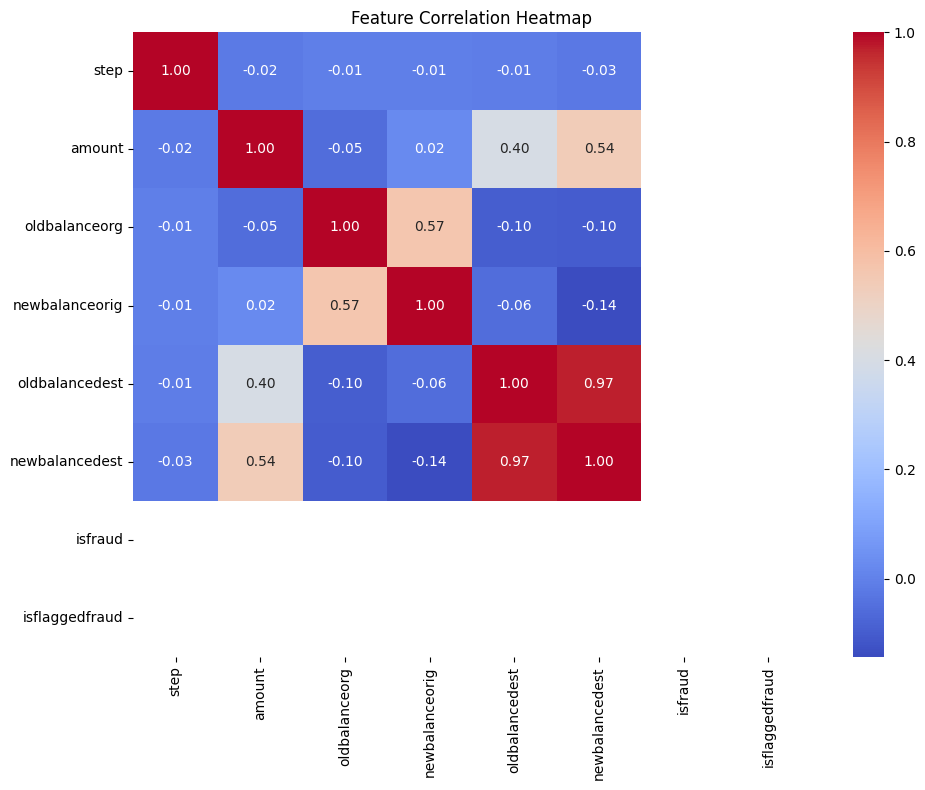

In [30]:
plt.figure(figsize=(10, 8))
sns.heatmap(adf.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

In [31]:
X = adf.drop('isfraud', axis=1)
y = adf['isfraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
X_train_clean = X_train.select_dtypes(include='number')
X_test_clean = X_test[X_train_clean.columns]
rfe_selector = RFE(estimator=RandomForestClassifier(n_estimators=100, random_state=42),
                   n_features_to_select=10)
rfe_selector.fit(X_train_clean, y_train)
selected_features = X_train_clean.columns[rfe_selector.support_]
print("Top 10 Selected Features:")
print(selected_features)

Top 10 Selected Features:
Index(['step', 'amount', 'oldbalanceorg', 'newbalanceorig', 'oldbalancedest',
       'newbalancedest', 'isflaggedfraud'],
      dtype='object')


In [48]:
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import pandas as pd
X_train_final = X_train_clean[selected_features].apply(pd.to_numeric, errors='coerce')
X_test_final = X_test_clean[selected_features].apply(pd.to_numeric, errors='coerce')
X_train_final.dropna(inplace=True)
X_test_final.dropna(inplace=True)
y_train_final = y_train.loc[X_train_final.index].astype(int)
y_test_final = y_test.loc[X_test_final.index].astype(int)
xgb = XGBClassifier(eval_metric='logloss',
                    use_label_encoder=False,
                    base_score=0.5,
                    random_state=42)
xgb.fit(X_train_final, y_train_final)
y_pred = xgb.predict(X_test_final)
y_probs = xgb.predict_proba(X_test_final)[:, 1]
print("Confusion Matrix:")
print(confusion_matrix(y_test_final, y_pred))
print("\nClassification Report:")
print(classification_report(y_test_final, y_pred))
print("\nROC AUC Score:", roc_auc_score(y_test_final, y_probs))

Confusion Matrix:
[[1295822]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1295822

    accuracy                           1.00   1295822
   macro avg       1.00      1.00      1.00   1295822
weighted avg       1.00      1.00      1.00   1295822


ROC AUC Score: nan


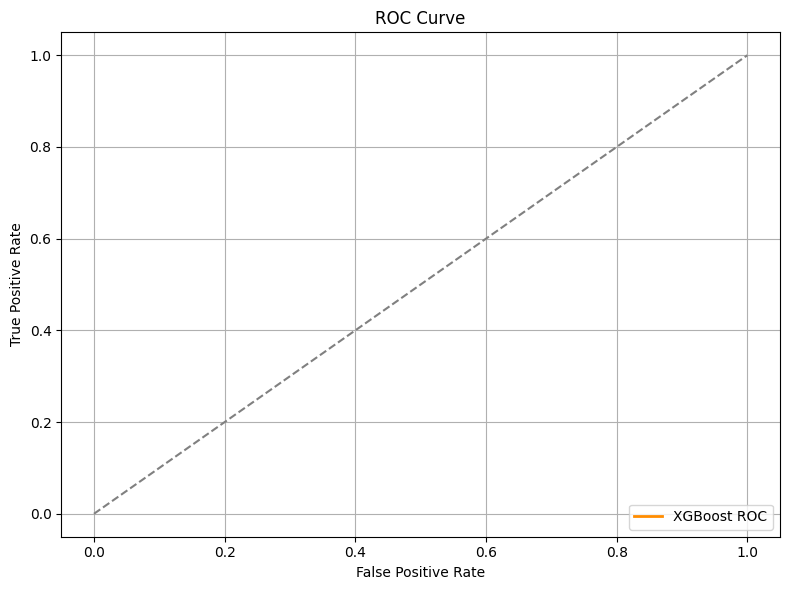

In [40]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt


fpr, tpr, _ = roc_curve(y_test_final, y_probs)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="XGBoost ROC", color="darkorange", lw=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal line for reference
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

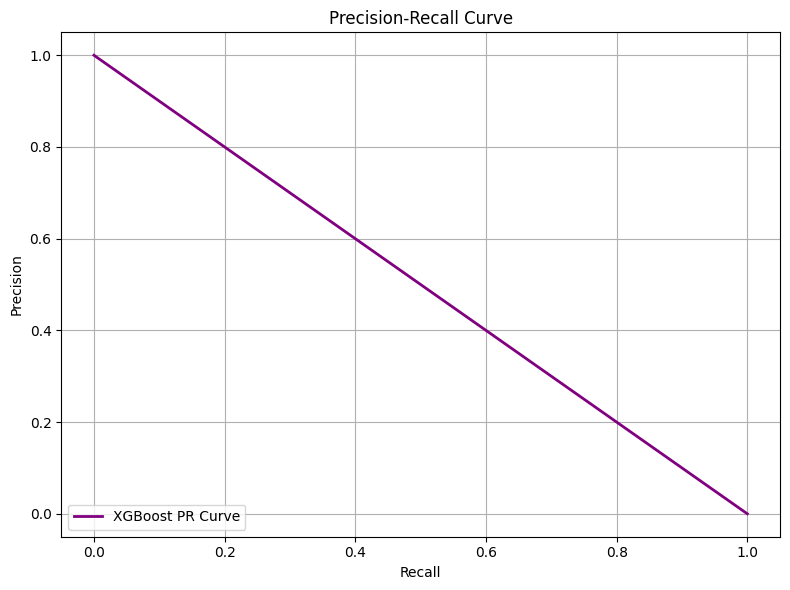

In [41]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
precision, recall, _ = precision_recall_curve(y_test_final, y_probs)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="XGBoost PR Curve", color="purple", lw=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

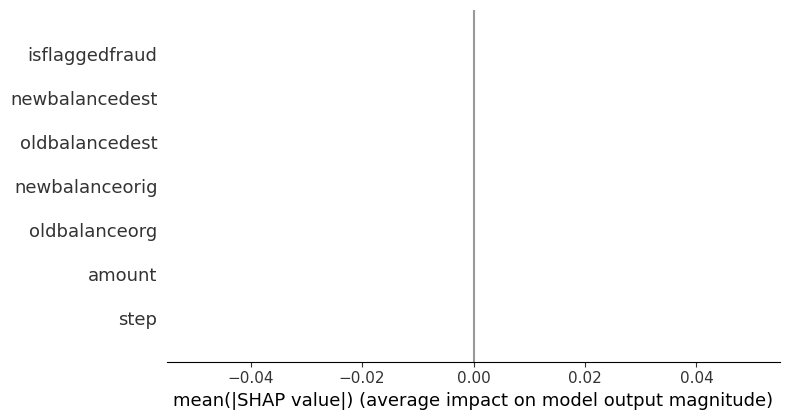

In [42]:
import shap
explainer = shap.TreeExplainer(xgb)
X_test_final = X_test_clean[selected_features].apply(pd.to_numeric, errors='coerce').dropna()
y_test_final = y_test.loc[X_test_final.index].astype(int)
shap_values = explainer.shap_values(X_test_final)
shap.summary_plot(shap_values, X_test_final, plot_type="bar")